## Importar librerias

In [ ]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.14.0
- Version scikit-learn: 1.5.0
- Version pandas: 2.2.3
- Version numpy: 1.26.4


## Funciones de utilidad

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el error porcentual absoluto medio.
    
    Parámetros:
    y_true (np.array): Valores reales.
    y_pred (np.array): Valores predichos.
    
    Retorna:
    float: Error porcentual absoluto medio.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Lectura del dataset

In [ ]:
# Cargar el archivo Excel
df = pd.read_excel("accesos.xlsx")

# Asegurar que la fecha esté en formato datetime
df['Fecha Completa'] = pd.to_datetime(df['Fecha Completa'])

# Crear variables temporales relevantes
df['Día'] = df['Fecha Completa'].dt.day
df['Mes'] = df['Fecha Completa'].dt.month
df['Año'] = df['Fecha Completa'].dt.year

# Codificar Jornada, Pregrado y Postgrado
df['Jornada'] = df['Jornada'].astype('category').cat.codes
df['Pregrado'] = df['Pregrado'].map({'SI': 1, 'NO': 0})
df['Postgrado'] = df['Postgrado'].map({'SI': 1, 'NO': 0})

# Crear una clave de fecha sin hora
df['Fecha'] = df['Fecha Completa'].dt.date

# Agrupar y contar accesos
daily_counts = df.groupby(['Fecha', 'Día', 'Mes', 'Año']).agg({
    'Jornada': 'count',
    'Pregrado': 'count',
    'Postgrado': 'count',
    'Fecha Completa': 'count'  # esto cuenta los accesos
}).rename(columns={'Fecha Completa': 'Accesos'}).reset_index()

In [3]:
daily_counts.head(10)

,Fecha,Día,Mes,Año,Jornada,Pregrado,Postgrado,Accesos
0,2023-12-14,14,12,2023,1.0,0.697796,0.017838,953
1,2023-12-15,15,12,2023,1.0,0.719490,0.009107,549
2,2023-12-16,16,12,2023,0.0,0.676056,0.028169,71
3,2023-12-18,18,12,2023,1.0,0.676590,0.020298,739
4,2023-12-19,19,12,2023,1.0,0.637076,0.020888,383
5,2023-12-20,20,12,2023,1.0,0.556485,0.025105,239
6,2023-12-21,21,12,2023,1.0,0.582938,0.047393,211
7,2023-12-22,22,12,2023,1.0,0.393443,0.032787,122
8,2024-01-02,2,1,2024,1.0,0.512821,0.025641,156
9,2024-01-03,3,1,2024,1.0,0.699153,0.008475,472


In [4]:
daily_counts.tail(10)

,Fecha,Día,Mes,Año,Jornada,Pregrado,Postgrado,Accesos
324,2025-04-24,24,4,2025,1.0,0.971698,0.004717,2544
325,2025-04-25,25,4,2025,1.0,0.971976,0.006637,1356
326,2025-04-26,26,4,2025,0.0,0.922053,0.013308,526
327,2025-04-27,27,4,2025,0.0,1.000000,0.000000,4
328,2025-04-28,28,4,2025,1.0,0.973333,0.007917,2400
329,2025-04-29,29,4,2025,1.0,0.971963,0.007009,2568
330,2025-04-30,30,4,2025,1.0,0.975367,0.007625,1705
331,2025-05-05,5,5,2025,1.0,0.977455,0.005455,2750
332,2025-05-06,6,5,2025,1.0,0.968917,0.002680,1866
333,2025-05-07,7,5,2025,1.0,0.980923,0.002218,2254


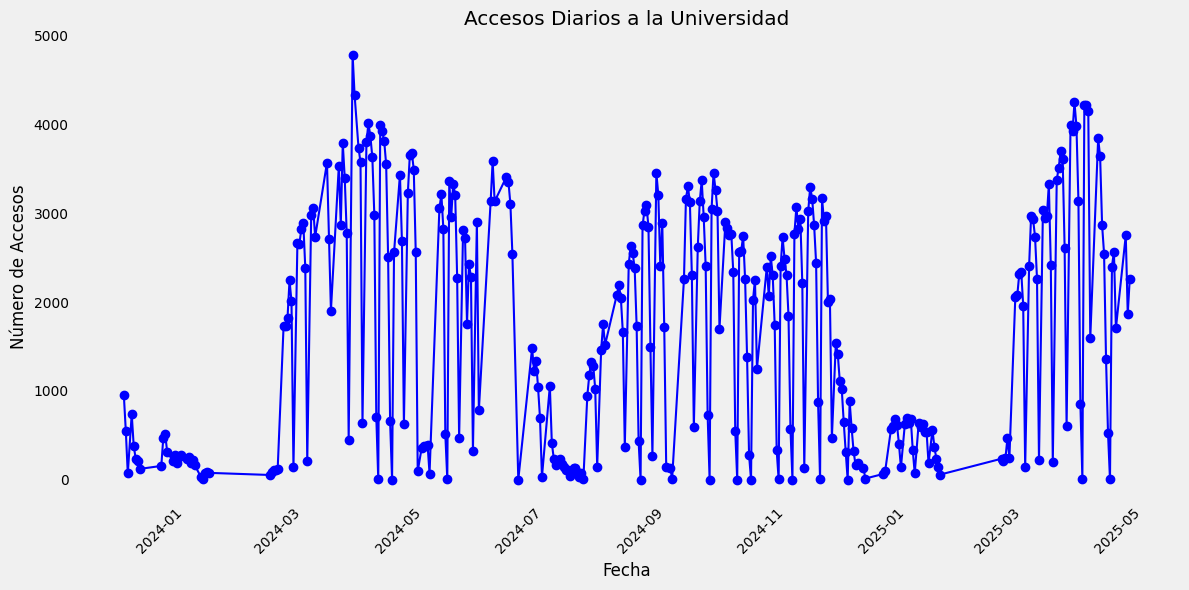

In [5]:
#graficar los datos
plt.figure(figsize=(12, 6))
plt.plot(daily_counts['Fecha'], daily_counts['Accesos'], marker='o', linestyle='-', color='b')
plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


## División de datos de entrenamiento y test


In [36]:
train_Size = int(len(daily_counts)*0.9)

train = daily_counts['Accesos'][:train_Size]
test = daily_counts['Accesos'][train_Size:]

In [37]:
train

0       953
1       549
2        71
3       739
4       383
       ... 
295    2737
296    2262
297     222
298    3035
299    2947
Name: Accesos, Length: 300, dtype: int64

In [38]:
test

300    2968
301    3325
302    2413
303     198
304    3373
305    3514
306    3695
307    3613
308    2610
309     603
310    3990
311    3923
312    4248
313    3976
314    3140
315     852
316      10
317    4218
318    4216
319    4145
320    1592
321    3841
322    3639
323    2867
324    2544
325    1356
326     526
327       4
328    2400
329    2568
330    1705
331    2750
332    1866
333    2254
Name: Accesos, dtype: int64

## Crear modelo


In [ ]:
# Crear y entrenar el modelo   
Daily_Use = ForecasterRecursive(
    regressor = RandomForestRegressor(random_state=123),
    lags = 3
)

Daily_Use.fit(y=train)

In [40]:
cv = TimeSeriesFold(
      steps              = 12,
      initial_train_size = int(len(train) * 0.5),
      refit              = True,
      fixed_train_size   = False,

    )

# Valores candidatos para los hiperparámetros
lags_grid = [3, 4, 6] 

param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 8, 15, 25],
}

results_grid = grid_search_forecaster(
                    forecaster  = Daily_Use,
                    y           = train,
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/15 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 1215434.107210613


In [41]:
regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 6
             )
forecaster.fit(y=train)


## Evaluación de rendimiento

In [42]:
predicted = forecaster.predict(steps=len(test))

In [43]:
predicted

300    2777.041619
301    2522.377426
302    2005.806790
303    1117.331126
304    1489.736387
305    1442.640609
306    1484.058767
307    1494.034588
308    1435.829769
309    1124.905809
310    1233.746934
311    1228.909471
312    1217.182148
313    1254.858670
314    1232.004964
315    1102.481321
316     888.249132
317     846.175066
318     768.425493
319     724.672269
320     634.158122
321     597.706868
322     497.208333
323     492.202775
324     484.626854
325     484.626854
326     474.881661
327     474.881661
328     474.881661
329     474.881661
330     474.881661
331     474.881661
332     474.881661
333     474.881661
Name: pred, dtype: float64

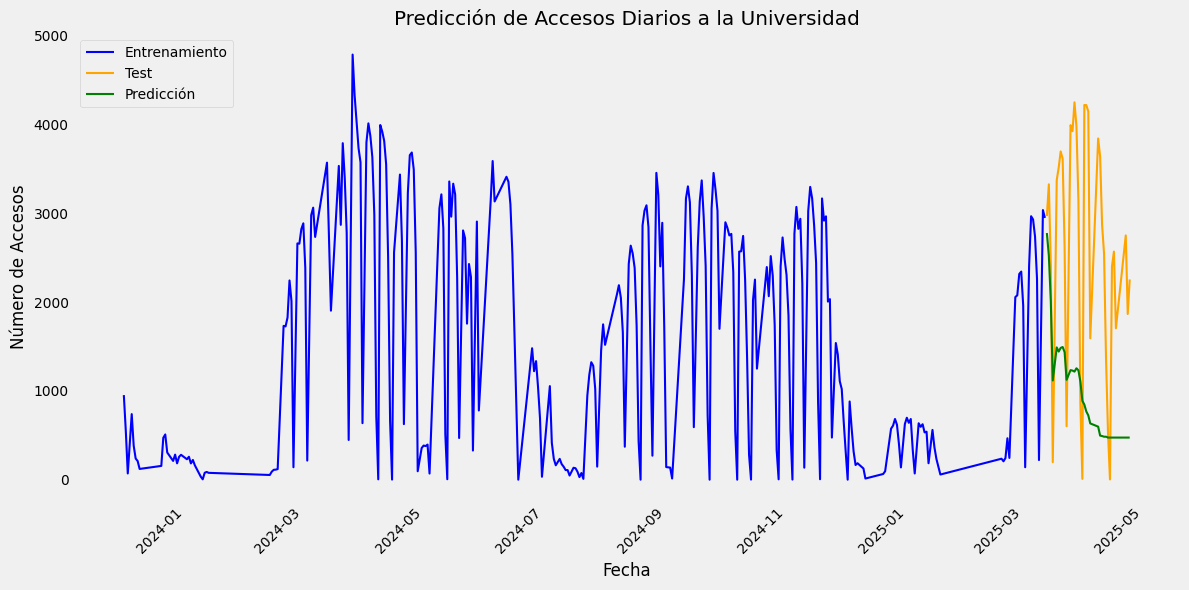

Error Cuadrático Medio (MSE): 4220013.78
Error Absoluto Medio (MAE): 1783.64
Error Porcentual Absoluto Medio (MAPE): 675.94%


In [44]:
# Grafico
plt.figure(figsize=(12, 6))
plt.plot(daily_counts['Fecha'][:train_Size], train, label='Entrenamiento', color='blue')
plt.plot(daily_counts['Fecha'][train_Size:], test, label='Test', color='orange')
plt.plot(daily_counts['Fecha'][train_Size:], predicted, label='Predicción', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Evaluación del modelo
mse = mean_squared_error(test, predicted)
mae = mean_absolute_error(test, predicted)
mape = mean_absolute_percentage_error(test, predicted)
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")
